In [1]:
import numpy as np

import matplotlib.pyplot as plt
plt.rcParams["text.usetex"] = False
from matplotlib import cm, colors
from matplotlib.patches import Ellipse
import matplotlib as mpl

from astropy.io import fits
from astropy.table import Table
from astropy.coordinates import SkyCoord
from astropy import units as u
from astropy.wcs import WCS
from astropy.visualization.wcsaxes import SphericalCircle

from scipy.ndimage import gaussian_filter1d

import os

import requests

from hyperfit.linfit import LinFit

import emcee

from scipy.optimize import minimize

import corner

import sys
sys.path.insert(1, '/Users/kellydouglass/Documents/Research/DESI/Targets/code/TF/')
from line_fits import param_invert, hyperfit_line

#from desispec.io import read_spectra
#from desispec.spectra import stack as specstack
#from desispec.coaddition import coadd_cameras

In [2]:
h = 1
H0 = 100*h

c = 3e5

q0 = 0.2

V0 = 2.5 # Set 0-pt of the TFR

# Data

## fuji

In [3]:
#tfuji = Table.read('/global/cfs/projectdirs/desi/science/td/pv/desi_pv_tf_fuji_healpix.fits')
tfuji = Table.read('/Users/kellydouglass/Documents/Research/data/DESI/SV/desi_pv_tf_fuji_healpix.fits')
tfuji[:5]

TARGETID,TARGET_RA,TARGET_DEC,HEALPIX,SURVEY,Z,ZERR,ZWARN,DELTACHI2,FILENAME,PVTYPE,SGA_ID,RA,DEC
int64,float64,float64,int64,bytes3,float64,float64,int64,float64,bytes63,bytes3,int64,float64,float64
1079550234591232,194.390863195343,27.5157211790145,10378,sv3,1.1235686466514,7.31685779475115e-05,4,3.28414569795132,fuji/healpix/sv3/bright/103/10378/redrock-sv3-bright-10378.fits,EXT,662902,194.39086319534337,27.51572117901454
1092744374124544,194.390863195343,27.5157211790145,10378,sv3,0.686773088332363,6.9756676262104e-05,4,0.786607094109058,fuji/healpix/sv3/dark/103/10378/redrock-sv3-dark-10378.fits,EXT,662902,194.39086319534337,27.51572117901454
1092744374124546,194.364461113654,27.5037185881314,10378,sv3,0.0242933923052181,4.95233472646785e-05,0,95.428411073226,fuji/healpix/sv3/dark/103/10378/redrock-sv3-dark-10378.fits,EXT,662902,194.36446111365385,27.50371858813136
1092744369930240,194.338458724402,27.4918902690326,10378,sv3,0.0264170223697961,0.00010139452689994,0,9.53278421035066,fuji/healpix/sv3/dark/103/10378/redrock-sv3-dark-10378.fits,EXT,662902,194.33845872440244,27.491890269032595
1092744374124545,194.377858465028,27.5098100780282,10378,sv3,0.211332646769145,6.68535116703737e-05,4,3.73989077657461,fuji/healpix/sv3/dark/103/10378/redrock-sv3-dark-10378.fits,EXT,662902,194.3778584650283,27.509810078028195


### Separate the fuji data into center and off-center observations

In [4]:
def firstdigit(n):
    """
    Return the first digit of a number.
    
    Parameters
    ----------
    n : int, float, or ndarray
        Number or list of numbers.
    
    Returns
    -------
    digit : int
        First digit of the number.
    """
    
    digit = np.trunc(n * 10**(-np.trunc(np.log10(n)))).astype(int)
    
    return digit

In [5]:
first_digits = firstdigit(tfuji['TARGETID'])

fuji_centers = tfuji[first_digits == 3]
fuji_axis = tfuji[first_digits != 3]

/var/folders/5x/2533z9ns34n_8ghxd5f6hl0c0000gn/T/ipykernel_20699/917620242.py:16: RuntimeWarning: invalid value encountered in log10
  digit = np.trunc(n * 10**(-np.trunc(np.log10(n)))).astype(int)
/var/folders/5x/2533z9ns34n_8ghxd5f6hl0c0000gn/T/ipykernel_20699/917620242.py:16: RuntimeWarning: invalid value encountered in cast
  digit = np.trunc(n * 10**(-np.trunc(np.log10(n)))).astype(int)


### Clean the fuji center observations

Only keep those with
 * DELTACHI2 > 25
 * ZWARN == 0

In [6]:
good_centers = fuji_centers[(fuji_centers['DELTACHI2'] > 25) & (fuji_centers['ZWARN'] == 0)]

#### Are there any galaxies with multiple good center observations?

In [7]:
unique_ids, counts = np.unique(good_centers['SGA_ID'], return_counts=True)

print(unique_ids[counts > 1], counts[counts > 1])

 SGA_ID
-------
    848
   3727
  26199
  37543
  46327
  83216
    ...
1284002
1285273
1319490
1366241
1380792
1382772
Length = 87 rows [2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 3 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2]


## SGA

In [8]:
#SGA = Table.read('/global/cfs/cdirs/cosmo/data/sga/2020/SGA-2020.fits', 'ELLIPSE')
SGA = Table.read('/Users/kellydouglass/Documents/Research/data/SGA/SGA-2020.fits', 'ELLIPSE')

SGA[:5]

SGA_ID,SGA_GALAXY,GALAXY,PGC,RA_LEDA,DEC_LEDA,MORPHTYPE,PA_LEDA,D25_LEDA,BA_LEDA,Z_LEDA,SB_D25_LEDA,MAG_LEDA,BYHAND,REF,GROUP_ID,GROUP_NAME,GROUP_MULT,GROUP_PRIMARY,GROUP_RA,GROUP_DEC,GROUP_DIAMETER,BRICKNAME,RA,DEC,D26,D26_REF,PA,BA,RA_MOMENT,DEC_MOMENT,SMA_MOMENT,G_SMA50,R_SMA50,Z_SMA50,SMA_SB22,SMA_SB22.5,SMA_SB23,SMA_SB23.5,SMA_SB24,SMA_SB24.5,SMA_SB25,SMA_SB25.5,SMA_SB26,G_MAG_SB22,R_MAG_SB22,Z_MAG_SB22,G_MAG_SB22.5,R_MAG_SB22.5,Z_MAG_SB22.5,G_MAG_SB23,R_MAG_SB23,Z_MAG_SB23,G_MAG_SB23.5,R_MAG_SB23.5,Z_MAG_SB23.5,G_MAG_SB24,R_MAG_SB24,Z_MAG_SB24,G_MAG_SB24.5,R_MAG_SB24.5,Z_MAG_SB24.5,G_MAG_SB25,R_MAG_SB25,Z_MAG_SB25,G_MAG_SB25.5,R_MAG_SB25.5,Z_MAG_SB25.5,G_MAG_SB26,R_MAG_SB26,Z_MAG_SB26,SMA_SB22_ERR,SMA_SB22.5_ERR,SMA_SB23_ERR,SMA_SB23.5_ERR,SMA_SB24_ERR,SMA_SB24.5_ERR,SMA_SB25_ERR,SMA_SB25.5_ERR,SMA_SB26_ERR,G_MAG_SB22_ERR,R_MAG_SB22_ERR,Z_MAG_SB22_ERR,G_MAG_SB22.5_ERR,R_MAG_SB22.5_ERR,Z_MAG_SB22.5_ERR,G_MAG_SB23_ERR,R_MAG_SB23_ERR,Z_MAG_SB23_ERR,G_MAG_SB23.5_ERR,R_MAG_SB23.5_ERR,Z_MAG_SB23.5_ERR,G_MAG_SB24_ERR,R_MAG_SB24_ERR,Z_MAG_SB24_ERR,G_MAG_SB24.5_ERR,R_MAG_SB24.5_ERR,Z_MAG_SB24.5_ERR,G_MAG_SB25_ERR,R_MAG_SB25_ERR,Z_MAG_SB25_ERR,G_MAG_SB25.5_ERR,R_MAG_SB25.5_ERR,Z_MAG_SB25.5_ERR,G_MAG_SB26_ERR,R_MAG_SB26_ERR,Z_MAG_SB26_ERR,G_COG_PARAMS_MTOT,G_COG_PARAMS_M0,G_COG_PARAMS_ALPHA1,G_COG_PARAMS_ALPHA2,G_COG_PARAMS_CHI2,R_COG_PARAMS_MTOT,R_COG_PARAMS_M0,R_COG_PARAMS_ALPHA1,R_COG_PARAMS_ALPHA2,R_COG_PARAMS_CHI2,Z_COG_PARAMS_MTOT,Z_COG_PARAMS_M0,Z_COG_PARAMS_ALPHA1,Z_COG_PARAMS_ALPHA2,Z_COG_PARAMS_CHI2,ELLIPSEBIT
int64,bytes16,bytes29,int64,float64,float64,bytes21,float32,float32,float32,float32,float32,float32,bool,bytes13,int64,bytes35,int16,bool,float64,float64,float32,bytes8,float64,float64,float32,bytes4,float32,float32,float64,float64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int32
2,SGA-2020 2,PGC1283207,1283207,228.3770865,5.4232017,S?,152.2,0.36307806,0.724436,0.03463229,23.40448,16.976,False,LEDA-20181114,0,PGC1283207,1,True,228.3770865,5.4232017,0.36307806,2283p055,228.3770803831908,5.423191398593787,0.49470574,SB26,158.20142,0.545691,228.37700918822188,5.4232652570544015,10.897086,3.3509698,3.1147978,3.240862,5.902337,6.9126143,7.941369,8.997992,10.073601,11.199986,12.391357,13.561038,14.841172,16.966799,16.108246,15.486356,16.879545,16.024958,15.400715,16.818878,15.967034,15.341793,16.776297,15.925804,15.300776,16.746685,15.897334,15.272053,16.725166,15.876816,15.2521105,16.708357,15.862035,15.237181,16.696539,15.851936,15.226998,16.689613,15.844313,15.21976,0.013392451,0.02354,0.021872982,0.01736985,0.024445537,0.039866067,0.05026544,0.08455789,0.122911856,0.005682776,0.0054258136,0.0049038026,0.005588406,0.005323561,0.0047632363,0.00543534,0.005177031,0.0046343105,0.0053025587,0.005040888,0.0045181247,0.005206092,0.0049438984,0.0044374703,0.0051483097,0.0048758644,0.0043834248,0.0051032505,0.0048264163,0.004344248,0.0050705094,0.004792021,0.004319857,0.005054293,0.004765629,0.0043044444,16.65942,0.34037337,0.2978292,3.0239506,0.07928849,15.820566,0.2640441,0.34559453,3.3033552,0.003811298,15.195567,0.29826432,0.3001073,3.2333765,0.011723555,0
3,SGA-2020 3,PGC1310416,1310416,202.54443750000002,6.9345944,Sc,159.26,0.4017908,0.7816278,0.073888786,23.498482,16.85,False,LEDA-20181114,1,PGC1310416,1,True,202.54443750000002,6.9345944,0.4017908,

In [9]:
SGA_dict = {}

for i in range(len(SGA)):
    
    SGA_dict[SGA['SGA_ID'][i]] = i

### If an SGA galaxy has at least one observation at its center, set the redshift of that galaxy

In [10]:
SGA['Z_DESI'] = np.nan
SGA['ZERR_DESI'] = np.nan

for sga_id in np.unique(good_centers['SGA_ID']):
    
    # Find the row in SGA for this galaxy
    SGA_idx = SGA_dict[sga_id]
    
    # Set the redshift of this galaxy to be the average redshift of all good center observations
    SGA['Z_DESI'][SGA_idx] = np.mean(good_centers['Z'][good_centers['SGA_ID'] == sga_id])
    SGA['ZERR_DESI'][SGA_idx] = np.mean(good_centers['ZERR'][good_centers['SGA_ID'] == sga_id]**2)/np.sum(good_centers['SGA_ID'] == sga_id)

# Coma cluster membership

Following Cosmicflows4 (Kourkchi et al. 2020), cluster membership is defined as
- $R_p < 1.5R_{2t}$ and $v < V_c \pm 3\sigma_p$
- $1.5R_{2t} \leq R_p < 3R_{2t}$ and $v < V_c \pm 2\sigma_p$

where $R_p$ is the projected distance from the cluster center, $R_{2t}$ is the cluster projected second turnaround radius, $\sigma_p$ is the projected velocity dispersion of the cluster, and $V_c$ is the average heliocentric radial velocity of the cluster.

In [11]:
# Data table #3 from Tully (2015)
hdu = fits.open('../Tully15-Table3.fits')
table3 = Table(hdu[1].data)
hdu.close()

table3[:5]

f_Nest,Nest,Nmb,PGC1,SGLON,SGLAT,logLK,<Vcmba>,DM,sigV,R2t,sigP,Mlum,CF
int16,int32,int16,int32,float64,float64,float64,int32,float64,int16,float64,int16,float64,float64
1,100001,136,44715,89.6226,8.1461,13.15,7331,34.33,886,2.129,1045,1710000000000000.0,1.65
1,100002,197,41220,103.0008,-2.3248,12.69,1491,30.87,670,1.44,707,529000000000000.0,1.0
1,100003,113,43296,156.2336,-11.5868,12.75,3873,32.94,822,1.52,746,623000000000000.0,1.12
1,100004,81,58265,71.5103,49.7851,13.16,9424,34.87,740,2.153,1057,1770000000000000.0,2.26
1,100005,61,36487,92.0255,-10.495,12.78,6987,34.22,707,1.56,766,673000000000000.0,1.58


In [12]:
Coma_nest = 100001

Coma_row_t3 = table3['Nest'] == Coma_nest

R2t_Coma = table3['R2t'][Coma_row_t3][0]
sigma_Coma = table3['sigP'][Coma_row_t3][0]

In [13]:
# Data table #2 from Tully et al. (2013)
hdu = fits.open('../Tully13-Table2.fit')
table2 = Table(hdu[1].data)
hdu.close()

table2[:5]

_RAJ2000,_DEJ2000,N1,__Dist_,__DM_,__Err_,N2,GLON,GLAT,SGLON,SGLAT,GMT,__Bmag_,__Kmag_,__HV_,__GV_,__Vls_,__Vcmb_,__Vcmba_,sigma,__PV_,__PVa_,Group,Ng,_2M__,PGCb,GName,_2M,Simbad,NED,recno
float64,float64,int16,float64,float64,float64,int16,float64,float64,float64,float64,int16,float64,float64,int32,int32,int32,int32,int32,int16,int32,int32,int16,int16,int16,int32,str10,str2,str6,str3,int32
266.404996,-28.936172,16,0.01,14.5,0.02,20,0.0,0.0,185.7861,42.3103,1,-6.0,-9.0,51,26,13,91,91,64,90,90,223,16,0,17223,Galaxy,2M,Simbad,NED,1
15.693346,36.392682,39,0.76,24.4,0.01,41,125.479,-26.423,322.2989,9.4579,2,3.4,0.68,-213,-49,17,-485,-484,156,-541,-547,222,39,0,2557,NGC0224,2M,Simbad,NED,2
149.896678,-12.831016,4,1.37,25.68,0.03,4,251.1365,32.2601,120.502,-42.5472,10,9.75,9.29,347,153,103,690,691,23,589,589,227,4,0,29128,NGC003109,2M,Simbad,NED,3
139.011477,52.840941,1,1.37,25.68,0.1,1,164.6636,42.8855,47.6118,-15.0125,10,13.75,11.5,-29,17,45,130,130,0,28,28,0,579,0,26142,UGC4879,2M,Simbad,NED,4
243.448636,54.37081,1,1.91,26.41,0.08,1,83.8788,44.4092,56.0935,40.37,10,16.69,12.9,-139,44,78,-121,-120,0,-262,-268,230,1,0,2801026,KKR25,2M,Simbad,NED,5


In [14]:
Coma_coords = SkyCoord(table3['SGLON'][Coma_row_t3]*u.degree, 
                       table3['SGLAT'][Coma_row_t3]*u.degree, 
                       frame='supergalactic')

group_coords = SkyCoord(table2['SGLON']*u.degree, 
                        table2['SGLAT']*u.degree, 
                        frame='supergalactic')

idx, d2d, d3d = Coma_coords.match_to_catalog_sky(group_coords)

V_Coma = table2['__HV_'][idx][0]

V_Coma

6899

## Calculate the projected distance between the Coma cluster and each SGA galaxy

In [15]:
# First, we need to convert R2t from Mpc to an angle, using the group's heliocentric velocity
R2t_Coma_angle = (R2t_Coma/(V_Coma/H0))*u.radian

In [16]:
SGA_coords = SkyCoord(SGA['RA'], SGA['DEC'], unit='deg')

sep = Coma_coords.separation(SGA_coords)

In [17]:
SGA_in_Coma1 = (sep < 1.5*R2t_Coma_angle) & (SGA['Z_DESI']*c > V_Coma - 3*sigma_Coma) & (SGA['Z_DESI']*c < V_Coma + 3*sigma_Coma)

SGA_in_Coma2 = (sep >= 1.5*R2t_Coma_angle) & (sep < 3*R2t_Coma_angle) & (SGA['Z_DESI']*c > V_Coma - 2*sigma_Coma) & (SGA['Z_DESI']*c < V_Coma + 2*sigma_Coma)
#SGA_in_Coma2 = (sep >= 1.5*R2t_Coma_angle) & (SGA['Z_DESI']*c > V_Coma - 2*sigma_Coma) & (SGA['Z_DESI']*c < V_Coma + 2*sigma_Coma)

SGA_in_Coma = SGA_in_Coma1 | SGA_in_Coma2

################################################################################
# Keep all observations of each galaxy that are within the Coma cluster
#-------------------------------------------------------------------------------
SGA_ID_in_Coma = SGA['SGA_ID'][SGA_in_Coma]

centers_inComa = good_centers[np.in1d(good_centers['SGA_ID'], SGA_ID_in_Coma)]

axis_inComa = fuji_axis[np.in1d(fuji_axis['SGA_ID'], SGA_ID_in_Coma)]
################################################################################

print('fuji galaxies in Coma with good center observations:', len(np.unique(centers_inComa['SGA_ID'])))
print('fuji off-center observations in Coma:', len(axis_inComa))

fuji galaxies in Coma with good center observations: 272
fuji off-center observations in Coma: 941


In [18]:
Christoph_removed = np.in1d(SGA['SGA_ID'], [309306, 455486, 486394, 1167691, 1269260])

print(SGA_in_Coma1[Christoph_removed])
print(SGA_in_Coma2[Christoph_removed])

[ True False False  True False]
[False  True  True False  True]


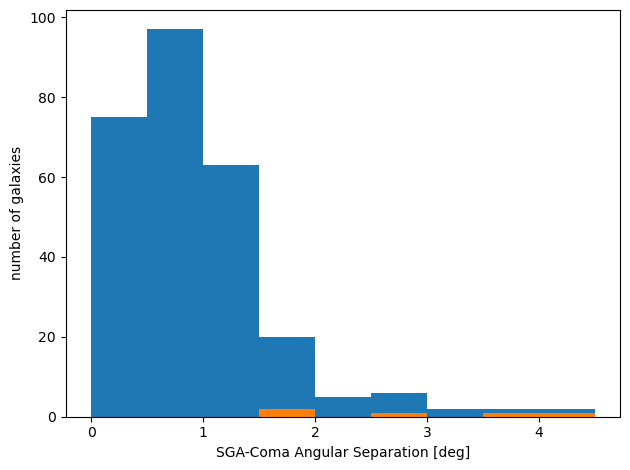

In [19]:
plt.figure(tight_layout=True)

plt.hist(sep[SGA_in_Coma].to_value('degree'), bins=np.arange(0, 5, 0.5))
plt.hist(sep[np.in1d(SGA['SGA_ID'], [309306, 455486, 486394, 1167691, 1269260])].to_value('degree'), bins=np.arange(0, 5, 0.5))

plt.xlabel('SGA-Coma Angular Separation [deg]')
plt.ylabel('number of galaxies');

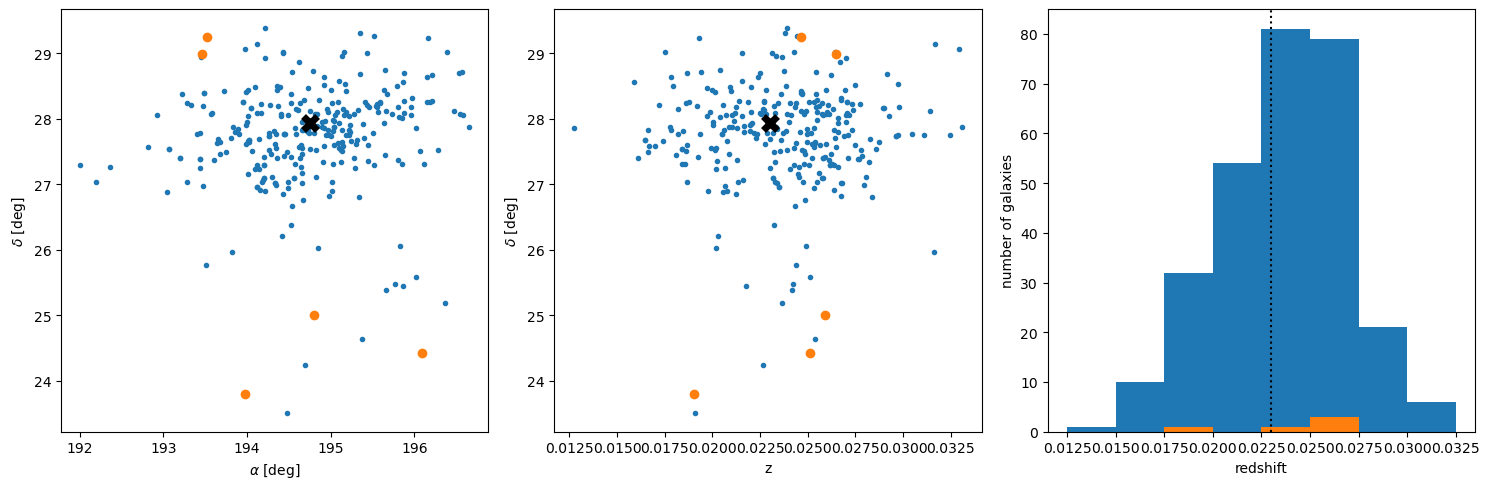

In [20]:
plt.figure(figsize=(15,5), tight_layout=True)

plt.subplot(131)
plt.plot(centers_inComa['TARGET_RA'], centers_inComa['TARGET_DEC'], '.')
plt.plot(centers_inComa['TARGET_RA'][np.in1d(centers_inComa['SGA_ID'], [309306, 455486, 486394, 1167691, 1269260])], 
         centers_inComa['TARGET_DEC'][np.in1d(centers_inComa['SGA_ID'], [309306, 455486, 486394, 1167691, 1269260])],
         'o')
plt.plot(Coma_coords.transform_to('icrs').ra.deg, Coma_coords.transform_to('icrs').dec.deg, 'kx', ms=10, mew=5)
plt.xlabel(r'$\alpha$ [deg]')
plt.ylabel(r'$\delta$ [deg]')

plt.subplot(132)
plt.plot(centers_inComa['Z'], centers_inComa['TARGET_DEC'], '.')
plt.plot(centers_inComa['Z'][np.in1d(centers_inComa['SGA_ID'], [309306, 455486, 486394, 1167691, 1269260])], 
         centers_inComa['TARGET_DEC'][np.in1d(centers_inComa['SGA_ID'], [309306, 455486, 486394, 1167691, 1269260])],
         'o')
plt.plot(V_Coma/c, Coma_coords.transform_to('icrs').dec.deg, 'kx', ms=10, mew=5)
plt.xlabel('z')
plt.ylabel(r'$\delta$ [deg]')

plt.subplot(133)
plt.hist(centers_inComa['Z'], bins=np.arange(0.0125, 0.035, 0.0025))
plt.hist(centers_inComa['Z'][np.in1d(centers_inComa['SGA_ID'], [309306, 455486, 486394, 1167691, 1269260])], bins=np.arange(0.0125, 0.035, 0.0025))
plt.vlines(V_Coma/c, 0, 85, colors='k', linestyles='dotted')
plt.xlabel('redshift')
plt.ylabel('number of galaxies')
plt.ylim(ymax=85);

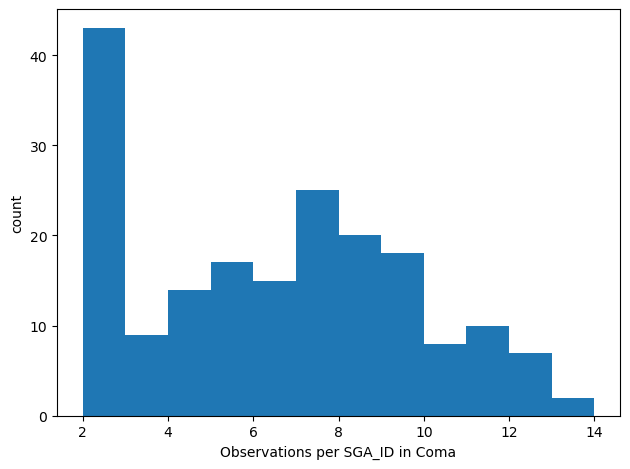

In [21]:
axis_SGAids, axis_counts = np.unique(axis_inComa['SGA_ID'], return_counts=True)
center_SGAids, center_counts = np.unique(centers_inComa['SGA_ID'], return_counts=True)

counts = []

for sga_id in SGA_ID_in_Coma:
    
    center_count = 0
    axis_count = 0
    
    if sga_id in center_SGAids:
        
        center_count = center_counts[center_SGAids == sga_id]
        
    if sga_id in axis_SGAids:
        
        axis_count = axis_counts[axis_SGAids == sga_id]
        
    count = center_count + axis_count
    
    if count > 1:
        
        counts.append(count)
        

plt.figure(tight_layout=True)

plt.hist(np.array(counts), bins=np.arange(2,15))

plt.xlabel('Observations per SGA_ID in Coma')
plt.ylabel('count');

# Calculate the rotational velocity

In [22]:
axis_inComa['SKY_FIBER_DIST'] = 0.
axis_inComa['SKY_FIBER_DIST_R26'] = 0.
axis_inComa['V_ROT'] = np.nan
axis_inComa['V_ROT_ERR'] = np.nan


# For each SGA galaxy that has at least one center observation, calculate the 
# distance for all of that galaxy's targets
for sga_gal in np.unique(centers_inComa['SGA_ID']):
    
    # Identify all galaxy targets on this galaxy
    obs_idx = axis_inComa['SGA_ID'] == sga_gal
    
    # Find galaxy index in SGA catalog
    sga_idx = SGA_dict[sga_gal]
    
    #---------------------------------------------------------------------------
    # Calculate distance between each observation and the center
    #---------------------------------------------------------------------------
    center_coords = SkyCoord(ra=SGA['RA'][sga_idx], 
                             dec=SGA['DEC'][sga_idx], 
                             unit=u.degree)
    target_coords = SkyCoord(ra=axis_inComa['RA'][obs_idx], 
                             dec=axis_inComa['DEC'][obs_idx], 
                             unit=u.degree)
    
    sep2d = target_coords.separation(center_coords)
    
    axis_inComa['SKY_FIBER_DIST'][obs_idx] = sep2d
    axis_inComa['SKY_FIBER_DIST_R26'][obs_idx] = 2*sep2d.to('arcmin')/(SGA['D26'][sga_idx]*u.arcmin)
    #---------------------------------------------------------------------------
    
    
    #---------------------------------------------------------------------------
    # Calculate rotational velocity
    #---------------------------------------------------------------------------
    # Use the average redshift of all center observations for the systemic velocity
    z_center = np.mean(SGA['Z_DESI'][sga_idx])
    z_err_center2 = SGA['ZERR_DESI'][sga_idx]**2

    # Calculate rotational velocity for all observations of the galaxy
    axis_inComa['V_ROT'][obs_idx] = c*(axis_inComa['Z'][obs_idx] - z_center)
    axis_inComa['V_ROT_ERR'][obs_idx] = c*np.sqrt(axis_inComa['ZERR'][obs_idx]**2 + z_err_center2)
    #---------------------------------------------------------------------------
    
    
    #---------------------------------------------------------------------------
    # Correct rotational velocities for inclination angle
    #---------------------------------------------------------------------------
    cosi2 = (SGA['BA'][sga_idx]**2 - q0**2)/(1 - q0**2)
    
    # Galaxies with b/a < q0
    if cosi2 < 0:
        cosi2 = 0
    
    axis_inComa['V_ROT'][obs_idx] /= np.sin(np.arccos(np.sqrt(cosi2)))
    #---------------------------------------------------------------------------

/var/folders/5x/2533z9ns34n_8ghxd5f6hl0c0000gn/T/ipykernel_20699/2270156695.py:56: RuntimeWarning: divide by zero encountered in divide
  axis_inComa['V_ROT'][obs_idx] /= np.sin(np.arccos(np.sqrt(cosi2)))


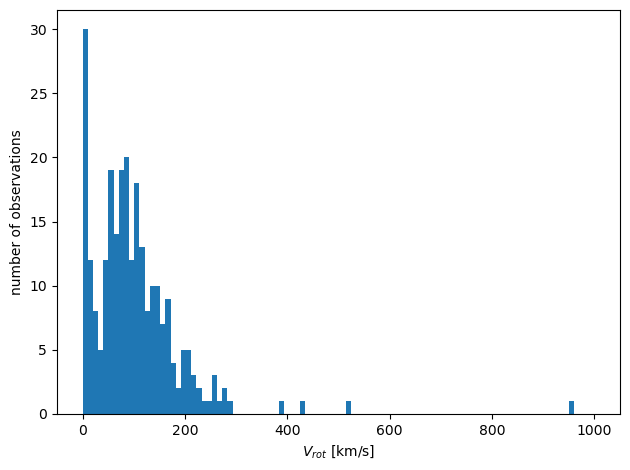

In [23]:
plt.figure(tight_layout=True)

plt.hist(np.abs(axis_inComa['V_ROT']), bins=np.linspace(0, 1000, 100))

plt.xlabel('$V_{rot}$ [km/s]')
plt.ylabel('number of observations');

# Cut for Coma galaxies suitable for calibrating the TFR

Requirements:
 * $V_{rot} < 1000$ km/s at $0.33R_{26}$
 * $i > 45^\circ$
 * Spiral-type morphology
 * Passes visual inspection

## Velocity cut

In [24]:
r0p3 = (axis_inComa['SKY_FIBER_DIST_R26'] > 0.3) & (axis_inComa['SKY_FIBER_DIST_R26'] < 0.4)

Vgood = np.abs(axis_inComa['V_ROT']) < 1000

good_axis_inComa = axis_inComa[r0p3 & Vgood]

print(len(good_axis_inComa), len(np.unique(good_axis_inComa['SGA_ID'])))

198 116


## Inclination angle cut

In [25]:
SGA['cosi2'] = (SGA['BA']**2 - q0**2)/(1 - q0**2)
SGA['cosi2'][SGA['cosi2'] < 0] = 0

good_axis_inComa['iSGA'] = -1

for i in range(len(good_axis_inComa)):
    
    # Find galaxy in SGA
    sga_idx = SGA_dict[good_axis_inComa['SGA_ID'][i]]
    
    good_axis_inComa['iSGA'][i] = sga_idx
    
good_axis_inComa['cosi2'] = SGA['cosi2'][good_axis_inComa['iSGA']]

In [26]:
i_min = 45. # degrees

cosi2_max = np.cos(i_min*np.pi/180.)**2

edge = good_axis_inComa['cosi2'] <= cosi2_max

good_edge_axis_inComa = good_axis_inComa[edge]

print(len(good_edge_axis_inComa), len(np.unique(good_edge_axis_inComa['SGA_ID'])))

155 93


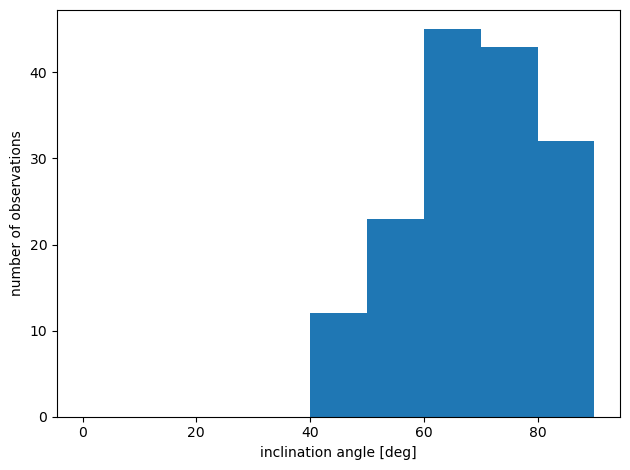

In [27]:
plt.figure(tight_layout=True)

plt.hist(np.arccos(np.sqrt(good_edge_axis_inComa['cosi2']))*180/np.pi, bins=np.linspace(0, 90, 10))

plt.xlabel('inclination angle [deg]')
plt.ylabel('number of observations');

## Morphology cut

In [28]:
good_edge_axis_inComa['MORPHTYPE'] = SGA['MORPHTYPE'][good_edge_axis_inComa['iSGA']]

In [29]:
spirals = np.zeros(len(good_edge_axis_inComa), dtype=bool)

for i in range(len(good_edge_axis_inComa)):
    
    try:    
        if (good_edge_axis_inComa['MORPHTYPE'][i][0] == 'S') and (good_edge_axis_inComa['MORPHTYPE'][i][:2] != 'S0'):
            spirals[i] = True
    except IndexError:
        print(good_edge_axis_inComa['MORPHTYPE'][i])

good_edge_spirals_axis_inComa = good_edge_axis_inComa[spirals]

print(len(good_edge_spirals_axis_inComa), len(np.unique(good_edge_spirals_axis_inComa['SGA_ID'])))

--
--
--
84 47


## Visual inspection cut

This removes any observations that are contaminated by foreground stars or other galaxies.

In [29]:
def get_cutout(targetid, ra, dec, size, verbose=False):
    """Grab and cache legacy survey cutouts.
    
    Parameters
    ----------
    targetid : int
        DESI target ID.
    ra : float
        Right ascension (degrees).
    dec : float
        Declination (degrees).
    verbose : bool
        Add some status messages if true.
        
    Returns
    -------
    img_name : str
        Name of JPG cutout file written after query.
    w : astropy.wcs.WCS
        World coordinate system for the image.
    """
    # Either load an existing image or download a cutout.
    img_name = 'cache/coma_{}.jpg'.format(targetid)
    
    if os.path.exists(img_name):
        if verbose:
            print('{} exists.'.format(img_name))
    else:
        img_url = 'https://www.legacysurvey.org/viewer/cutout.jpg?ra={}&dec={}&zoom=14&layer=ls-dr9&size={}&sga'.format(ra, dec, size)
        if verbose:
            print('Get {}'.format(img_url))
            
        with open(img_name, 'wb') as handle: 
            response = requests.get(img_url, stream=True) 
            if not response.ok: 
                print(response) 
            for block in response.iter_content(1024): 
                if not block: 
                    break 
                handle.write(block)
                
    # Set up the WCS.
    wcs_input_dict = {
        'CTYPE1': 'RA---TAN',
        'CUNIT1': 'deg',
        'CDELT1': -0.262/3600,
        'CRPIX1': size/2 + 0.5,
        'CRVAL1': ra,
        'NAXIS1': size,
        'CTYPE2': 'DEC--TAN',
        'CUNIT2': 'deg',
        'CDELT2': 0.262/3600,
        'CRPIX2': size/2 + 0.5,
        'CRVAL2': dec,
        'NAXIS2': size
    }
    w = WCS(wcs_input_dict)
    
    return img_name, w

cache/coma_39627776214435213.jpg exists.
INFO:spectra.py:291:read_spectra: iotime 4.317 sec to read spectra-sv3-bright-26004.fits at 2022-09-02T16:10:03.413145


TypeError: 'AxesSubplot' object is not subscriptable

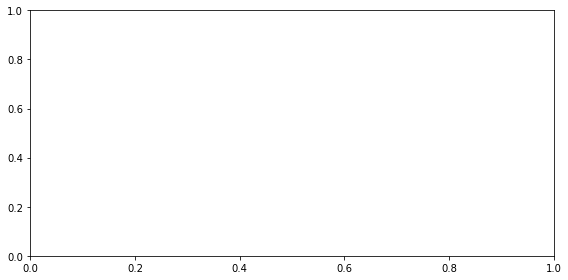

In [183]:
for sga_id in np.unique(good_edge_spirals_axis_inComa['SGA_ID']):
    
    tf_list = good_edge_spirals_axis_inComa[good_edge_spirals_axis_inComa['SGA_ID'] == sga_id]
    center_list = centers_inComa[centers_inComa['SGA_ID'] == sga_id]
    
    try:
        targetid = int(center_list['TARGETID'][0])
    except TypeError as err:
        print(err)
        # print(sga_galaxy['TARGETID'])
        continue
    
    ra, dec, z = float(SGA['RA'][SGA_dict[sga_id]]), float(SGA['DEC'][SGA_dict[sga_id]]), float(SGA['Z_DESI'][SGA_dict[sga_id]])
    
    # D26 in arcmin
    d26 = SGA['D26'][SGA_dict[sga_id]]
    
    # Padd the image cutout of the galaxy.
    # Multiply by 60 (to arcsec), divide by 180 to get pixscale.
#     pixscale = 1.05*d26*60/180
    npix = np.minimum(int(1.025 * d26*60/0.262), 512)
    
    #print(targetid, sga_id, ra, dec)
#     img_file = get_cutout(targetid, ra, dec, size=npix, verbose=True)
    img_file, wcs = get_cutout(targetid, ra, dec, size=npix, verbose=True)
    img = mpl.image.imread(img_file)

    fig1 = plt.figure(figsize=(7,5))

    ax = fig1.add_subplot(111, projection=wcs)
    ax.imshow(np.flip(img, axis=0))
    ax.set(xlabel='ra', ylabel='dec')
    ax.text(int(0.02*npix), int(0.85*npix), 'TARGETID: {}\nSGA_ID: {}\n$z={{{:.4f}}}$'.format(targetid, sga_id, z), fontsize=9, color='yellow')
    overlay = ax.get_coords_overlay('icrs')
    overlay.grid(color='white', ls='dotted');

    # Add the location of the DESI fibers.
    # SDSS fibers are 2" diameter, DESI is 107 um with 70 um/" plate scale.
    r1 = SphericalCircle((ra * u.deg, dec * u.deg), (107./70) * u.arcsec,
                         edgecolor='black', facecolor='none', alpha=0.8, lw=3,
                         transform=ax.get_transform('icrs'))
    r2 = SphericalCircle((ra * u.deg, dec * u.deg), (107./70) * u.arcsec,
                         edgecolor='red', facecolor='none', alpha=0.8, lw=2,
                         transform=ax.get_transform('icrs'))
    ax.add_patch(r1)
    ax.add_patch(r2)

    for tft in tf_list:
        ra, dec = tft['RA'], tft['DEC']
        
        edgecolor2 = 'orange'
#         if tft['Z'] > 0.05:
#             edgecolor2 = 'orange'
#         else:
#             edgecolor2 = 'lime'
        
        # Add the location of the DESI fibers.
        # SDSS fibers are 2" diameter, DESI is 107 um with 70 um/" plate scale.
        r1 = SphericalCircle((ra * u.deg, dec * u.deg), (107./70) * u.arcsec,
                             edgecolor='lightcoral', facecolor='none', alpha=1, lw=3,
                             transform=ax.get_transform('icrs'))
        r2 = SphericalCircle((ra * u.deg, dec * u.deg), (107./70) * u.arcsec,
                             edgecolor=edgecolor2, facecolor='none', alpha=0.8, lw=2,
                             transform=ax.get_transform('icrs'))
        ax.add_patch(r1)
        ax.add_patch(r2)
        
        ax.text(ra, dec, str(tft['TARGETID']), transform=ax.get_transform('icrs'), color='white')
    
    fig1.subplots_adjust(top=0.85, right=0.85, bottom=0.15, left=0.15)
    
    fig1.savefig('cache/fuji_VI_cutouts/dist_{}.png'.format(sga_id), dpi=120)
    
    fig1.clear()
    plt.close(fig1)
    
    #----------------------------------------------------------------------------------
    # Get spectra
    #----------------------------------------------------------------------------------
    coadds = get_spectra_for_sga(good_edge_spirals_axis_inComa, sga_id)
    n = coadds.num_spectra()

    fig2, axes = plt.subplots(n,1, figsize=(8,4*n), sharex=True, sharey=True, tight_layout=True)

    for i in range(n):
        wave = coadds.wave['brz']
        flux = coadds.flux['brz'][i]
        smoothed = gaussian_filter1d(flux, 7)

        ax = axes[i]
        ax.plot(wave, smoothed, label='TARGETID: {}'.format(coadds.fibermap['TARGETID'][i]))
        ax.set(ylabel=r'flux [$10^{-17}$ erg cm$^{-2}$ s$^{-1}$ $\AA^{-1}$]')
        if i+1 == n:
            ax.set(xlabel=r'$\lambda_\mathrm{obs}$ [$\AA$]')

        ax.legend(loc='upper right', fontsize=10)
    
    # figure = PdfPages('cache/DM_cutouts/dist_{}.pdf'.format(sga_id))
    # figure.savefig(fig1, dpi = 300)
    # figure.savefig(fig2, dpi = 120)
    # figure.close()
    
    break

In [30]:
VI_remove = Table.read('fuji_Coma_VI.txt', format='ascii.commented_header')

remove_targets = np.zeros(len(good_edge_spirals_axis_inComa), dtype=bool)

for targetid in VI_remove['TARGETID']:
    
    remove_targets = remove_targets & (good_edge_spirals_axis_inComa['TARGETID'] == targetid)
    
VI_good_edge_spirals_axis_inComa = good_edge_spirals_axis_inComa[~remove_targets]

print(len(VI_good_edge_spirals_axis_inComa), len(np.unique(VI_good_edge_spirals_axis_inComa['SGA_ID'])))

84 47


# Coma TFR

## Compute the weighted average velocity for those galaxies with more than one observation at $0.33R_{26}$:

\begin{equation}
  \overline{v} = \frac{\sum_i w_i v_i}{\sum_i w_i}
\end{equation}
where $w_i = 1/\sigma^2$.

In [31]:
SGA['V_0p33R26'] = np.nan
SGA['V_0p33R26_err'] = np.nan

weights = 1./(VI_good_edge_spirals_axis_inComa['V_ROT_ERR']**2)

for sga_id in np.unique(VI_good_edge_spirals_axis_inComa['SGA_ID']):
    
    # Identify all galaxy targets on this galaxy
    obs_idx = VI_good_edge_spirals_axis_inComa['SGA_ID'] == sga_id
    
    SGA['V_0p33R26'][SGA_dict[sga_id]] = np.average(np.abs(VI_good_edge_spirals_axis_inComa['V_ROT'][obs_idx]), 
                                                    weights=weights[obs_idx])

    SGA['V_0p33R26_err'][SGA_dict[sga_id]] = np.sqrt(1./np.sum(weights[obs_idx]))

In [32]:
# Make a catalog of just those galaxies with velocities
SGA_TF = SGA[np.isfinite(SGA['V_0p33R26']) & (SGA['R_MAG_SB26'] > 0)]

Christoph_removed = np.in1d(SGA_TF['SGA_ID'], [309306, 455486, 486394, 1167691, 1269260])

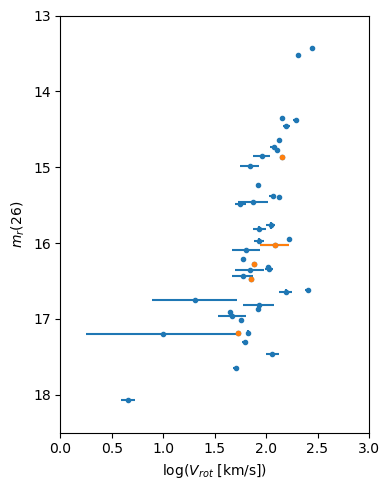

In [33]:
plt.figure(figsize=(4,5), tight_layout=True)

plt.errorbar(np.log10(SGA_TF['V_0p33R26']), 
             SGA_TF['R_MAG_SB26'], 
             xerr=0.434*SGA_TF['V_0p33R26_err']/SGA_TF['V_0p33R26'],
             yerr=SGA_TF['R_MAG_SB26_ERR'], 
             fmt='.')
plt.errorbar(np.log10(SGA_TF['V_0p33R26'][Christoph_removed]), 
             SGA_TF['R_MAG_SB26'][Christoph_removed], 
             xerr=0.434*SGA_TF['V_0p33R26_err'][Christoph_removed]/SGA_TF['V_0p33R26'][Christoph_removed],
             yerr=SGA_TF['R_MAG_SB26_ERR'][Christoph_removed], 
             fmt='.')

plt.xlim([0, 3])
plt.ylim([18.5, 13])

plt.xlabel('log($V_{rot}$ [km/s])')
plt.ylabel('$m_r (26)$');

## Fit the TFR using `hyperfit`

### Create covariance matrix for `hyperfit`

In [34]:
Ndata = len(SGA_TF)
cov = np.empty((2, 2, Ndata))

# loop over arrays of uncertainties in logv and mag
# Assume diagonal covariance for each measurement.
for i in range(Ndata):
    cov[:,:,i] = np.array([[(0.434*SGA_TF['V_0p33R26_err'][i]/SGA_TF['V_0p33R26'][i])**2, 0.], [0., SGA_TF['R_MAG_SB26_ERR'][i]**2]])

### Create `hyperfit` object

In [35]:
hf = LinFit([np.log10(SGA_TF['V_0p33R26']) - V0, SGA_TF['R_MAG_SB26']], cov)

### Run MCMC to fit TFR

In [36]:
bounds = ((-10.0, 10.0), (-1000.0, 1000.0), (1.0e-5, 500.0))

mcmc_samples, mcmc_lnlike = hf.emcee(bounds, verbose=True)

print(np.mean(mcmc_samples, axis=1), np.std(mcmc_samples, axis=1))

 message: Optimization terminated successfully.
 success: True
     fun: -43.69265220517125
       x: [ 2.140e+00  3.703e-01  2.053e-01]
     nit: 160
    nfev: 7261
     jac: [-4.080e-03  3.173e-03 -4.238e-02]


100%|█████████████████████████████████████| 1000/1000 [00:00<00:00, 1008.40it/s]


Niterations/Max Iterations:  1000 / 100000
Integrated ACT/Min Convergence Iterations:  [54.9553673 54.5201893 39.3421306] / 2747.7683649022433


100%|█████████████████████████████████████| 1000/1000 [00:00<00:00, 1092.05it/s]


Niterations/Max Iterations:  2000 / 100000
Integrated ACT/Min Convergence Iterations:  [86.4495637  86.46467728 46.04723324] / 4323.233863781477


100%|█████████████████████████████████████| 1000/1000 [00:00<00:00, 1142.97it/s]


Niterations/Max Iterations:  3000 / 100000
Integrated ACT/Min Convergence Iterations:  [128.97900128 128.77186243  67.54192874] / 6448.950063935157


100%|█████████████████████████████████████| 1000/1000 [00:00<00:00, 1124.60it/s]


Niterations/Max Iterations:  4000 / 100000
Integrated ACT/Min Convergence Iterations:  [165.4708047  158.95474817  63.57869361] / 8273.540234920116


100%|█████████████████████████████████████| 1000/1000 [00:00<00:00, 1157.77it/s]


Niterations/Max Iterations:  5000 / 100000
Integrated ACT/Min Convergence Iterations:  [169.51028785 164.84390349  54.14246213] / 8475.514392715191


100%|█████████████████████████████████████| 1000/1000 [00:00<00:00, 1130.65it/s]


Niterations/Max Iterations:  6000 / 100000
Integrated ACT/Min Convergence Iterations:  [130.10439638 133.06984998  67.89974242] / 6653.492498929157


100%|█████████████████████████████████████| 1000/1000 [00:00<00:00, 1154.62it/s]


Niterations/Max Iterations:  7000 / 100000
Integrated ACT/Min Convergence Iterations:  [126.36024391 125.62362651  63.97492045] / 6318.012195648305


100%|█████████████████████████████████████| 1000/1000 [00:00<00:00, 1126.34it/s]


Niterations/Max Iterations:  8000 / 100000
Integrated ACT/Min Convergence Iterations:  [132.38800194 134.26659918  70.25790169] / 6713.329958833508


100%|█████████████████████████████████████| 1000/1000 [00:00<00:00, 1152.10it/s]


Niterations/Max Iterations:  9000 / 100000
Integrated ACT/Min Convergence Iterations:  [137.68268198 138.80158264  80.45820973] / 6940.0791321867855


100%|█████████████████████████████████████| 1000/1000 [00:00<00:00, 1138.09it/s]


Niterations/Max Iterations:  10000 / 100000
Integrated ACT/Min Convergence Iterations:  [149.03119019 147.82374921  81.64916521] / 7451.559509254535


100%|█████████████████████████████████████| 1000/1000 [00:00<00:00, 1153.47it/s]


Niterations/Max Iterations:  11000 / 100000
Integrated ACT/Min Convergence Iterations:  [161.64002391 160.12938982  79.86674715] / 8082.001195334242


100%|█████████████████████████████████████| 1000/1000 [00:00<00:00, 1132.75it/s]


Niterations/Max Iterations:  12000 / 100000
Integrated ACT/Min Convergence Iterations:  [173.85622545 174.09982475  71.31286413] / 8704.991237727852


100%|█████████████████████████████████████| 1000/1000 [00:00<00:00, 1149.23it/s]


Niterations/Max Iterations:  13000 / 100000
Integrated ACT/Min Convergence Iterations:  [173.18303288 171.43321932  69.76140506] / 8659.151644068124
[-5.64656201 12.81249212  1.2519399 ] [1.05407424 0.60875792 0.26865157]


### Plot the Hyperfit

After the linear fit MCMC, construct the bestfit line and its 1-sigma uncertainties.

Also plot the measurements as ellipses with the size given by the uncertainties in log(v) and $m_r$, and the color given by the best-fit scatter parameter $\sigma_i$.

Code taken from plotting examples in [hyperfit documentation](https://hyperfit.readthedocs.io/en/latest/tutorial.html#a-simple-best-fit).

In [37]:
a, b, sig    = np.median(mcmc_samples, axis=1)
da, db, dsig = np.std(mcmc_samples, axis=1)

for val, err in zip((a, b, sig), (da, db, dsig)):
    print('{:6.2f} +/- {:.2f}'.format(val, err))

 -5.50 +/- 1.05
 12.89 +/- 0.61
  1.21 +/- 0.27


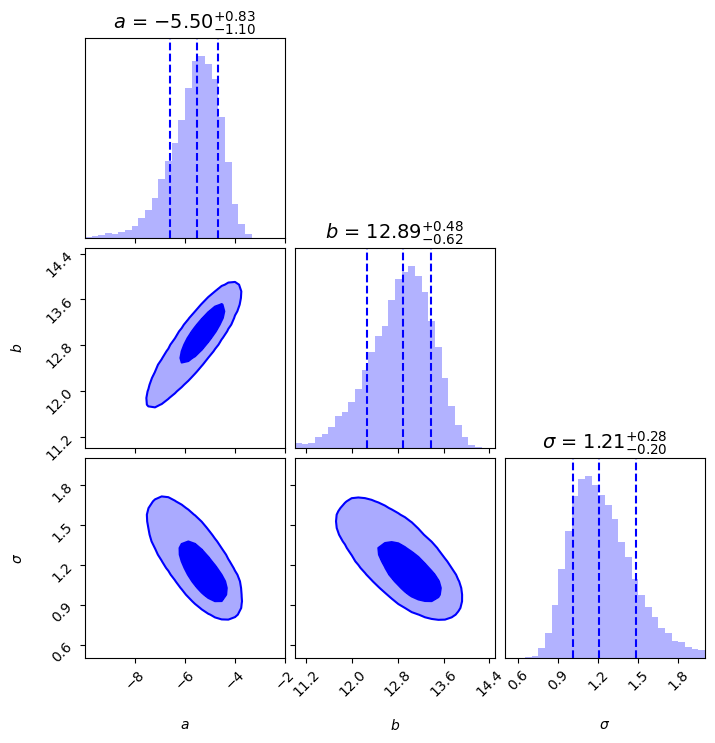

In [38]:
fig = corner.corner(mcmc_samples.T, bins=30, smooth=1,
             range=[[-10, -2], [11, 14.5], [0.5, 2]],   # Range for a, b, sigma. Adjust as needed.
             labels=['$a$', '$b$', r'$\sigma$'],
             levels=(1-np.exp(-0.5), 1-np.exp(-2)),
             quantiles=[0.16, 0.5, 0.84],
             color='blue',
             hist_kwargs={'histtype':'stepfilled', 'alpha':0.3},
             plot_datapoints=False,
             fill_contours=True,
             show_titles=True,
             title = {'Coma'},
             title_kwargs={"fontsize": 14})

#fig.savefig('../../Figures/SV/fuji_Coma_corner_20221013.png', dpi=150)

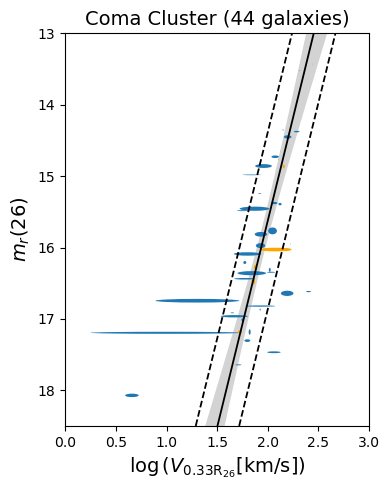

In [39]:
sigmas = hf.get_sigmas()
xvals = np.linspace(1., 3., 1000)
yvals = hf.coords[0] * (xvals - V0) + hf.coords[1]

# Get the MCMC 1-sigma quantiles to plot with the fit.
y_chain = np.outer(xvals - V0, mcmc_samples[0]) + mcmc_samples[1]
y_chain_quantiles = np.quantile(y_chain, [0.1587, 0.8414], axis=1)

# Pack info into data
data = [np.log10(SGA_TF['V_0p33R26']), SGA_TF['R_MAG_SB26']]
x_err = 0.434*SGA_TF['V_0p33R26_err']/SGA_TF['V_0p33R26']
y_err = SGA_TF['R_MAG_SB26_ERR']
corr_xy = np.zeros_like(x_err)

# Removed galaxies
data_removed = [np.log10(SGA_TF['V_0p33R26'][Christoph_removed]), SGA_TF['R_MAG_SB26'][Christoph_removed]]
x_err_removed = 0.434*SGA_TF['V_0p33R26_err'][Christoph_removed]/SGA_TF['V_0p33R26'][Christoph_removed]
y_err_removed = SGA_TF['R_MAG_SB26_ERR'][Christoph_removed]
corr_xy_removed = np.zeros_like(x_err_removed)

# Generate ellipses
ells = [
    Ellipse(
        xy=[data[0][i], data[1][i]],
        width=2*y_err[i],
        height=2*x_err[i],
        angle=np.rad2deg(np.arccos(corr_xy[i])),
    )
    for i in range(len(data[0]))
]
ells_removed = [
    Ellipse(
        xy=[data_removed[0][i], data_removed[1][i]],
        width=2*y_err_removed[i],
        height=2*x_err_removed[i],
        angle=np.rad2deg(np.arccos(corr_xy_removed[i])),
    )
    for i in range(len(data_removed[0]))
]

# Make the plot
'''
fig = plt.figure(figsize=(3,5))
ax = fig.add_axes([0.15, 0.15, 1.03, 0.83])
'''
fig, ax = plt.subplots(figsize=(4,5), tight_layout=True)
ax.fill_between(xvals, y_chain_quantiles[0], y_chain_quantiles[1], color="lightgray")
for i, e in enumerate(ells):
    ax.add_artist(e)
    #e.set_color(cm.winter(sigmas[i] / np.amax(sigmas)))
    e.set_edgecolor('None')
    #e.set_alpha(0.9)
for i, e in enumerate(ells_removed):
    ax.add_artist(e)
    e.set_color('orange')
    #e.set_edgecolor('None')
ax.plot(xvals, yvals, c="k", marker="None", ls="-", lw=1.3)#, alpha=0.9)
ax.plot(xvals, yvals - hf.vert_scat, c="k", marker="None", ls="--", lw=1.3)#, alpha=0.9)
ax.plot(xvals, yvals + hf.vert_scat, c="k", marker="None", ls="--", lw=1.3)#, alpha=0.9)
ax.set_xlabel(r"$\log{(V_\mathrm{0.33R_{26}} [\mathrm{km/s}])}$", fontsize=14)
ax.set_ylabel(r"$m_r(26)$", fontsize=14)
ax.set_title("Coma Cluster ({} galaxies)".format(len(SGA_TF)), fontsize = 14)
ax.set_xlim(0, 3)
ax.set_ylim(18.5, 13)
'''
# Add the colourbar
cb = fig.colorbar(
    cm.ScalarMappable(norm=colors.Normalize(vmin=0.0, vmax=np.amax(sigmas)), cmap=cm.winter),
    ax=ax,
    shrink=0.5,
    aspect=10,
    anchor=(-8, 0.95),
)
cb.set_label(label=r"$\sigma$", fontsize=14)
''';

#plt.savefig('../../Figures/SV/fuji_Coma_TFR_20221013.png', dpi=150)

In [41]:
SGA_TF['SGA_ID', 'PGC', 'RA', 'DEC', 'Z_DESI', 'V_0p33R26'].show_in_notebook()

idx,SGA_ID,PGC,RA,DEC,Z_DESI,V_0p33R26
0,25532,4107586,195.97667146704435,28.31062379047577,0.0267297616862906,44.65396060931472
1,98934,44212,194.20691376173056,27.093895925073287,0.0231520454727899,193.24217686760358
2,122260,4352806,195.84774376778842,27.30687826270548,0.0185712346342628,62.85335292303597
3,191275,1819621,194.57594096774397,27.848482700176607,0.025336855907803,20.176075305828697
4,196592,1813789,193.63830652599466,27.63275185427826,0.0243870264586433,157.36044493696974
5,202666,126751,195.21296726515683,27.742983900813208,0.0271247732365204,59.13058333024288
6,221178,43632,193.06742023100352,27.533158743696088,0.01842743057509275,83.41458816190627
7,291879,94015,195.4332574375834,28.999533006612396,0.0215321518628244,118.5012382060194
8,309306,1860194,193.52651601324948,29.242658555733755,0.024646069664789,121.5193910387515
9,337817,1829562,194.1681558468321,28.21765798682762,0.0277290772613727,155.66791432189316


## Fit for the slope using $\chi^2$

How does this fit compare to `hyperfit`'s?  Are the uncertainties larger?

### First, fit using `scipy.optimize.minimize`

This is to find where to start the MCMC.

In [40]:
def line_to_fit(params, x):
    '''
    Equation of a line
    
    
    PARAMETERS
    ==========
    
    params : list of length 2
        [slope, y-intercept]
    
    x : np.ndarray of shape (n,)
        x-values of line
    
    
    RETURNS
    =======
    
    y : np.ndarray of shape (n,)
        y-values calculated with the provided inputs
    '''
    
    m, b = params
    
    y = m*x + b
    
    return y

In [41]:
def calculate_chi2(params, x, x_err, y, y_err):
    '''
    Calculate the chi2 value of the current line.
    
    
    PARAMETERS
    ==========
    
    params : list of length 2
        [slope, y-intercept]
    
    x, x_err : np.ndarrays of shape (n,)
        x-values and uncertainties in the x-values
    
    y, y_err : np.ndarrays of shape (n,)
        y-values and uncertainties in the y-values
    
    
    RETURNS
    =======
    
    chi2 : float
        Chi2 value of the current best fit
    '''
    
    m, b = params
    
    ############################################################################
    # Calculate the values of the current best-fit line
    #---------------------------------------------------------------------------
    y_fit = line_to_fit(params, x)
    ############################################################################
    
    
    ############################################################################
    # Calculate chi2 of current fit
    #---------------------------------------------------------------------------
    chi2 = np.sum((y - y_fit)**2/(y_err**2 + (m*x_err)**2))
    ############################################################################
    
    return chi2

In [42]:
# Set the initial guess values for minimize to be the solutions from hyperfit
p0_guess = [a, b]

result = minimize(calculate_chi2, 
                  p0_guess, 
                  args=(np.log10(SGA_TF['V_0p33R26']) - V0, 0.434*SGA_TF['V_0p33R26_err']/SGA_TF['V_0p33R26'], SGA_TF['R_MAG_SB26'], SGA_TF['R_MAG_SB26_ERR']), 
                  bounds=[bounds[0], bounds[1]])

result

  message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
  success: True
   status: 0
      fun: 14724.53926202178
        x: [-5.738e+00  1.289e+01]
      nit: 9
      jac: [-1.819e-03  1.819e-04]
     nfev: 33
     njev: 11
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>

In [43]:
uncertainties = np.sqrt(np.diag(result.hess_inv.todense()))

print(f'slope: {result.x[0]:.2f} +/- {uncertainties[0]:.3f}')
print(f'y-intercept: {result.x[1]:.2f} +/- {uncertainties[1]:.3f}')

slope: -5.74 +/- 0.060
y-intercept: 12.89 +/- 0.009


### Now, use MCMC to fit for the parameters

We use the fit values from `minimize` to seed the walkers.

In [44]:
# Flat prior
def log_prior(params):
    
    m, b = params
    
    if (bounds[0][0] < m < bounds[0][1]) and (bounds[1][0] < b < bounds[1][1]):
        return 0.
    
    return -np.inf


# Log likelihood
def logl(params, x, dx, y, dy):
    
    m, b = params
    
    chi2 = calculate_chi2(params, x, dx, y, dy)
    
    s2 = dy**2 + (m*dx)**2
    
    return -0.5*(chi2 + np.sum(np.log(s2)))


# Posterior function
def log_prob(params, x, dx, y, dy):
    
    lp = log_prior(params)
    
    if not np.isfinite(lp):
        return -np.inf
    
    return lp + logl(params, x, dx, y, dy)

In [45]:
rng = np.random.default_rng()

pos = result.x + rng.standard_normal((32, len(result.x)))
nwalkers, ndim = pos.shape

sampler = emcee.EnsembleSampler(nwalkers, 
                                ndim, 
                                log_prob, 
                                args=(np.log10(SGA_TF['V_0p33R26']) - V0, 0.434*SGA_TF['V_0p33R26_err']/SGA_TF['V_0p33R26'], SGA_TF['R_MAG_SB26'], SGA_TF['R_MAG_SB26_ERR']))
sampler.run_mcmc(pos, 5000, progress=True);

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [01:15<00:00, 66.08it/s]


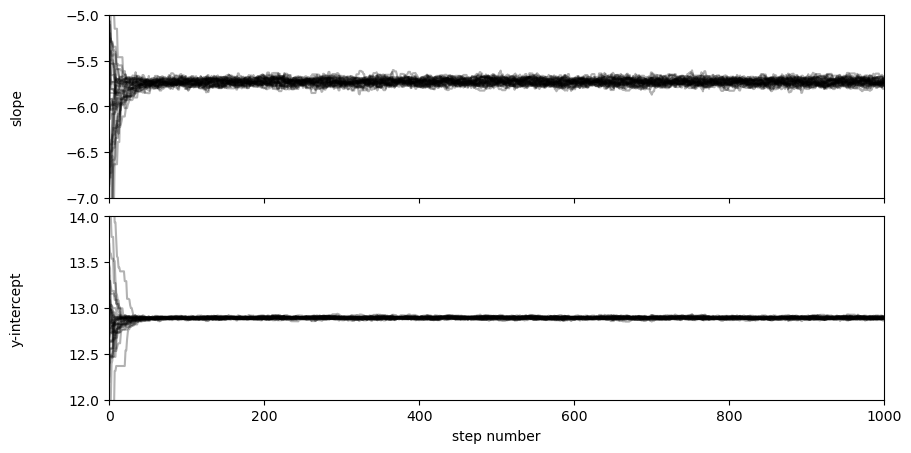

In [46]:
fig, axes = plt.subplots(2, 1, figsize=(10,5), sharex=True, gridspec_kw={'hspace':0.1})

samples = sampler.get_chain()

labels = ['slope', 'y-intercept']
yrange = [(-7, -5), (12, 14)]
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:1000,:,i], 'k', alpha=0.3)
    ax.set(xlim=(0,1000), ylim=yrange[i], ylabel=labels[i])
    ax.yaxis.set_label_coords(-0.11, 0.5)

axes[-1].set_xlabel('step number');

In [47]:
tau = sampler.get_autocorr_time()
print(tau)

[28.3138888  23.38753212]


In [48]:
flat_samples = sampler.get_chain(discard=100, thin=15, flat=True)
print(flat_samples.shape)

(10432, 2)


In [49]:
my_a, my_b   = np.mean(flat_samples, axis=0)
my_da, my_db = np.std(flat_samples, axis=0)

for val, err in zip((my_a, my_b), (my_da, my_db)):
    print('{:6.2f} +/- {:.3f}'.format(val, err))

 -5.73 +/- 0.034
 12.89 +/- 0.011


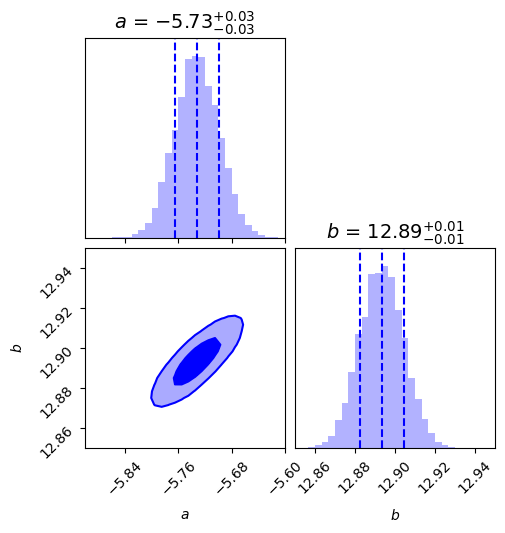

In [50]:
fig = corner.corner(flat_samples, bins=30, smooth=1,
                    range=[[-5.9, -5.6], [12.85, 12.95]],   # Range for a, b. Adjust as needed.
                    labels=['$a$', '$b$'],
                    levels=(1-np.exp(-0.5), 1-np.exp(-2)),
                    quantiles=[0.16, 0.5, 0.84],
                    color='blue',
                    hist_kwargs={'histtype':'stepfilled', 'alpha':0.3},
                    plot_datapoints=False,
                    fill_contours=True,
                    show_titles=True,
                    title = {'Coma'},
                    title_kwargs={"fontsize": 14})

#fig.savefig('../../Figures/SV/fuji_Coma_corner_20221013.png', dpi=150)

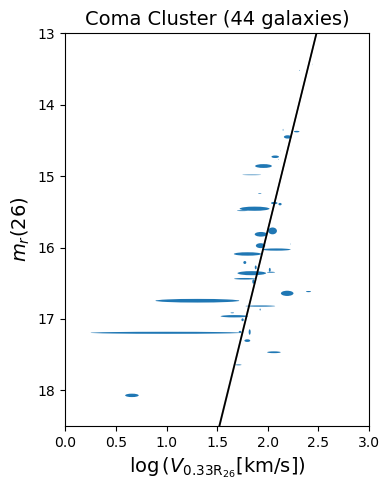

In [51]:
#sigmas = hf.get_sigmas()
xvals = np.linspace(1., 3., 1000)
yvals = my_a * (xvals - V0) + my_b

# Get the MCMC 1-sigma quantiles to plot with the fit.
y_chain = np.outer(xvals - V0, flat_samples[:,0]) + flat_samples[:,1]
y_chain_quantiles = np.quantile(y_chain, [0.1587, 0.8414], axis=1)

# Pack info into data
data = [np.log10(SGA_TF['V_0p33R26']), SGA_TF['R_MAG_SB26']]
x_err = 0.434*SGA_TF['V_0p33R26_err']/SGA_TF['V_0p33R26']
y_err = SGA_TF['R_MAG_SB26_ERR']
corr_xy = np.zeros_like(x_err)

# Generate ellipses
ells = [
    Ellipse(
        xy=[data[0][i], data[1][i]],
        width=2*y_err[i],
        height=2*x_err[i],
        angle=np.rad2deg(np.arccos(corr_xy[i])),
    )
    for i in range(len(data[0]))
]
# Make the plot
fig, ax = plt.subplots(figsize=(4,5), tight_layout=True)
ax.fill_between(xvals, y_chain_quantiles[0], y_chain_quantiles[1], color="lightgray")
for i, e in enumerate(ells):
    ax.add_artist(e)
    e.set_edgecolor('None')
ax.plot(xvals, yvals, c="k", marker="None", ls="-", lw=1.3)#, alpha=0.9)
ax.set_xlabel(r"$\log{(V_\mathrm{0.33R_{26}} [\mathrm{km/s}])}$", fontsize=14)
ax.set_ylabel(r"$m_r(26)$", fontsize=14)
ax.set_title("Coma Cluster ({} galaxies)".format(len(SGA_TF)), fontsize = 14)
ax.set_xlim(0, 3)
ax.set_ylim(18.5, 13);

## Fit for the slope using Linear Least Squares

This is what Cosmicflows-4 used.  And, in the spirit of Cosmicflows-4, we will be ignoring the uncertainties in the magnitudes.

How does this fit compare to `hyperfit`'s and MCMC's?

**Note**: In order to do this, we need to swap $x$ and $y$, so that the uncertainties in the velocities are on the dependent variable.

In [52]:
x = SGA_TF['R_MAG_SB26']
y = np.log10(SGA_TF['V_0p33R26']) - V0
yerr = 0.434*SGA_TF['V_0p33R26_err']/SGA_TF['V_0p33R26']

A = np.vander(x, 2)
C = np.diag(yerr*yerr)

ATA = np.dot(A.T, A/(yerr**2)[:, None])

cov = np.linalg.inv(ATA)

w = np.linalg.solve(ATA, np.dot(A.T, y/yerr**2))

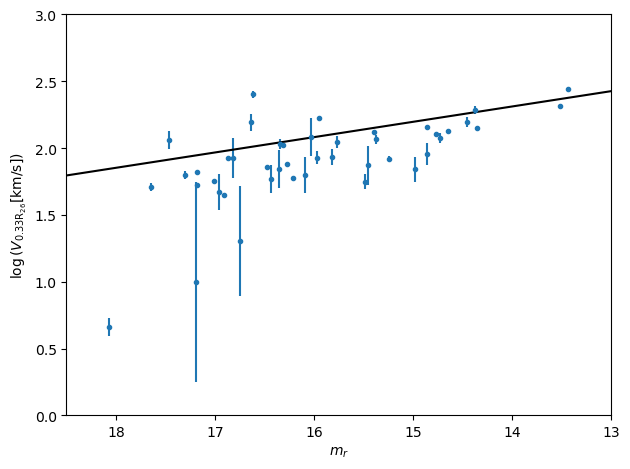

In [61]:
plt.figure(tight_layout=True)

plt.errorbar(x, y + V0, yerr=yerr, fmt='.')

plt.plot([13,19], w[0]*np.array([13,19]) + w[1] + V0, 'k')

plt.xlabel('$m_r$')
plt.ylabel(r"$\log{(V_\mathrm{0.33R_{26}} [\mathrm{km/s}])}$")

plt.xlim(18.5, 13)
plt.ylim(0, 3);

### Now we need to flip these back into the slope and y-intercepts that we've been fitting for.

In [53]:
lls_m = 1./w[0]
lls_b = -w[1]/w[0]

lls_dm = lls_m**2 * np.sqrt(cov[0,0])
lls_db = np.sqrt( (lls_b/w[0])**2 * cov[0,0] + lls_m**2 * cov[1,1] + 2*(lls_b/lls_m**2) * cov[1,0] )

print(f'{lls_m:.2f} +/- {lls_dm:.3f}')
print(f'{lls_b:.2f} +/- {lls_db:.3f}')

-8.72 +/- 0.035
12.36 +/- 0.078


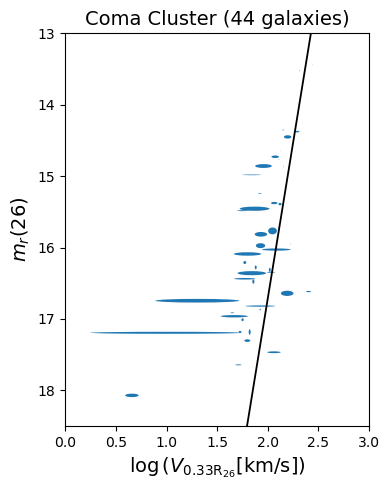

In [54]:
#sigmas = hf.get_sigmas()
xvals = np.linspace(1., 3., 1000)
yvals = lls_m * (xvals - V0) + lls_b

# Get the MCMC 1-sigma quantiles to plot with the fit.
#y_chain = np.outer(xvals - V0, flat_samples[:,0]) + flat_samples[:,1]
#y_chain_quantiles = np.quantile(y_chain, [0.1587, 0.8414], axis=1)

# Pack info into data
data = [np.log10(SGA_TF['V_0p33R26']), SGA_TF['R_MAG_SB26']]
x_err = 0.434*SGA_TF['V_0p33R26_err']/SGA_TF['V_0p33R26']
y_err = SGA_TF['R_MAG_SB26_ERR']
corr_xy = np.zeros_like(x_err)

# Generate ellipses
ells = [
    Ellipse(
        xy=[data[0][i], data[1][i]],
        width=2*y_err[i],
        height=2*x_err[i],
        angle=np.rad2deg(np.arccos(corr_xy[i])),
    )
    for i in range(len(data[0]))
]
# Make the plot
fig, ax = plt.subplots(figsize=(4,5), tight_layout=True)
#ax.fill_between(xvals, y_chain_quantiles[0], y_chain_quantiles[1], color="lightgray")
for i, e in enumerate(ells):
    ax.add_artist(e)
    e.set_edgecolor('None')
ax.plot(xvals, yvals, c="k", marker="None", ls="-", lw=1.3)#, alpha=0.9)
ax.set_xlabel(r"$\log{(V_\mathrm{0.33R_{26}} [\mathrm{km/s}])}$", fontsize=14)
ax.set_ylabel(r"$m_r(26)$", fontsize=14)
ax.set_title("Coma Cluster ({} galaxies)".format(len(SGA_TF)), fontsize = 14)
ax.set_xlim(0, 3)
ax.set_ylim(18.5, 13);

## Fit the ITFR using `hyperfit`

In [34]:
bounds_itfr = ((-1000.0, 1000.0), (-10.0, 10.0), (1.0e-5, 500.0))

w0, w1, sig_w, cov_w, itfr_mcmc_samples, hf_itfr = hyperfit_line(SGA_TF['R_MAG_SB26'], 
                                                                 np.log10(SGA_TF['V_0p33R26']) - V0, 
                                                                 SGA_TF['R_MAG_SB26_ERR'], 
                                                                 0.434*SGA_TF['V_0p33R26_err']/SGA_TF['V_0p33R26'], 
                                                                 bounds_itfr)

 message: Optimization terminated successfully.
 success: True
     fun: -43.692653371132344
       x: [ 3.706e-01  2.141e+00  2.053e-01]
     nit: 155
    nfev: 7048
     jac: [ 2.593e-03  1.330e-03  1.009e-04]


100%|█████████████████████████████████████| 1000/1000 [00:00<00:00, 1161.62it/s]


Niterations/Max Iterations:  1000 / 100000
Integrated ACT/Min Convergence Iterations:  [73.27346319 74.09259041 42.3700694 ] / 3704.629520483564


100%|█████████████████████████████████████| 1000/1000 [00:00<00:00, 1183.75it/s]


Niterations/Max Iterations:  2000 / 100000
Integrated ACT/Min Convergence Iterations:  [95.08499278 95.70691866 53.2494684 ] / 4785.345932754031


100%|█████████████████████████████████████| 1000/1000 [00:00<00:00, 1229.17it/s]


Niterations/Max Iterations:  3000 / 100000
Integrated ACT/Min Convergence Iterations:  [71.87093741 74.14297507 52.34570027] / 3707.148753422002


100%|█████████████████████████████████████| 1000/1000 [00:00<00:00, 1192.96it/s]


Niterations/Max Iterations:  4000 / 100000
Integrated ACT/Min Convergence Iterations:  [118.5028311  120.2507048   58.29961576] / 6012.535240047236


100%|█████████████████████████████████████| 1000/1000 [00:00<00:00, 1214.23it/s]


Niterations/Max Iterations:  5000 / 100000
Integrated ACT/Min Convergence Iterations:  [130.78652883 132.19978305  58.73691473] / 6609.989152668729


100%|█████████████████████████████████████| 1000/1000 [00:00<00:00, 1221.11it/s]


Niterations/Max Iterations:  6000 / 100000
Integrated ACT/Min Convergence Iterations:  [147.04992901 148.6975483   54.05523805] / 7434.877415141697


100%|█████████████████████████████████████| 1000/1000 [00:00<00:00, 1230.68it/s]


Niterations/Max Iterations:  7000 / 100000
Integrated ACT/Min Convergence Iterations:  [158.73175785 159.59663561  55.08467255] / 7979.831780673473


100%|█████████████████████████████████████| 1000/1000 [00:00<00:00, 1220.30it/s]


Niterations/Max Iterations:  8000 / 100000
Integrated ACT/Min Convergence Iterations:  [151.81812081 152.47669238  59.46142807] / 7623.834619128135


100%|█████████████████████████████████████| 1000/1000 [00:00<00:00, 1235.22it/s]


Niterations/Max Iterations:  9000 / 100000
Integrated ACT/Min Convergence Iterations:  [173.51511621 174.49845789  56.64039471] / 8724.922894608872


100%|█████████████████████████████████████| 1000/1000 [00:00<00:00, 1228.09it/s]


Niterations/Max Iterations:  10000 / 100000
Integrated ACT/Min Convergence Iterations:  [181.35941774 182.68938788  60.18261682] / 9134.469394150838


100%|█████████████████████████████████████| 1000/1000 [00:00<00:00, 1235.30it/s]


Niterations/Max Iterations:  11000 / 100000
Integrated ACT/Min Convergence Iterations:  [169.35567995 169.10388619  62.75786545] / 8467.7839975209


100%|█████████████████████████████████████| 1000/1000 [00:00<00:00, 1222.63it/s]


Niterations/Max Iterations:  12000 / 100000
Integrated ACT/Min Convergence Iterations:  [161.62324251 160.92002202  63.65447548] / 8081.1621255594755


100%|█████████████████████████████████████| 1000/1000 [00:00<00:00, 1224.10it/s]


Niterations/Max Iterations:  13000 / 100000
Integrated ACT/Min Convergence Iterations:  [166.25766935 170.50253259  63.26531078] / 8525.126629505956


100%|█████████████████████████████████████| 1000/1000 [00:00<00:00, 1234.55it/s]


Niterations/Max Iterations:  14000 / 100000
Integrated ACT/Min Convergence Iterations:  [176.67478837 186.19793998  75.73847121] / 9309.896998996155


100%|█████████████████████████████████████| 1000/1000 [00:00<00:00, 1240.36it/s]


Niterations/Max Iterations:  15000 / 100000
Integrated ACT/Min Convergence Iterations:  [190.47032752 211.63258701  88.08009589] / 10581.629350700512


100%|█████████████████████████████████████| 1000/1000 [00:00<00:00, 1203.21it/s]


Niterations/Max Iterations:  16000 / 100000
Integrated ACT/Min Convergence Iterations:  [230.42283338 256.05061236  86.97237611] / 12802.53061817169


100%|█████████████████████████████████████| 1000/1000 [00:00<00:00, 1169.17it/s]


Niterations/Max Iterations:  17000 / 100000
Integrated ACT/Min Convergence Iterations:  [261.96181284 288.18518134  92.75508992] / 14409.259067189734


100%|█████████████████████████████████████| 1000/1000 [00:00<00:00, 1217.27it/s]


Niterations/Max Iterations:  18000 / 100000
Integrated ACT/Min Convergence Iterations:  [265.58317857 293.38934943  89.74762562] / 14669.467471570628


In [35]:
a_itfr, b_itfr, cov_itfr = param_invert(w0, w1, cov_w[:2,:2])

print(f'      slope: {a_itfr:.2f} +/- {np.sqrt(cov_itfr[0,0]):.2f}')
print(f'y-intercept: {b_itfr:.2f} +/- {np.sqrt(cov_itfr[1,1]):.2f}')

      slope: -5.55 +/- 1.15
y-intercept: 12.86 +/- 0.67


### Plot the Hyperfit

After the linear fit MCMC, construct the bestfit line and its 1-sigma uncertainties.

Also plot the measurements as ellipses with the size given by the uncertainties in log(v) and $m_r$, and the color given by the best-fit scatter parameter $\sigma_i$.

Code taken from plotting examples in [hyperfit documentation](https://hyperfit.readthedocs.io/en/latest/tutorial.html#a-simple-best-fit).

In [36]:
# Invert the MCMC samples so that they represent (a, b) and not (w0, w1)
tfr_mcmc_samples = np.zeros(itfr_mcmc_samples.shape)

tfr_mcmc_samples[0] = 1./itfr_mcmc_samples[0]
tfr_mcmc_samples[1] = -itfr_mcmc_samples[1]/itfr_mcmc_samples[0]
tfr_mcmc_samples[2] = itfr_mcmc_samples[2]

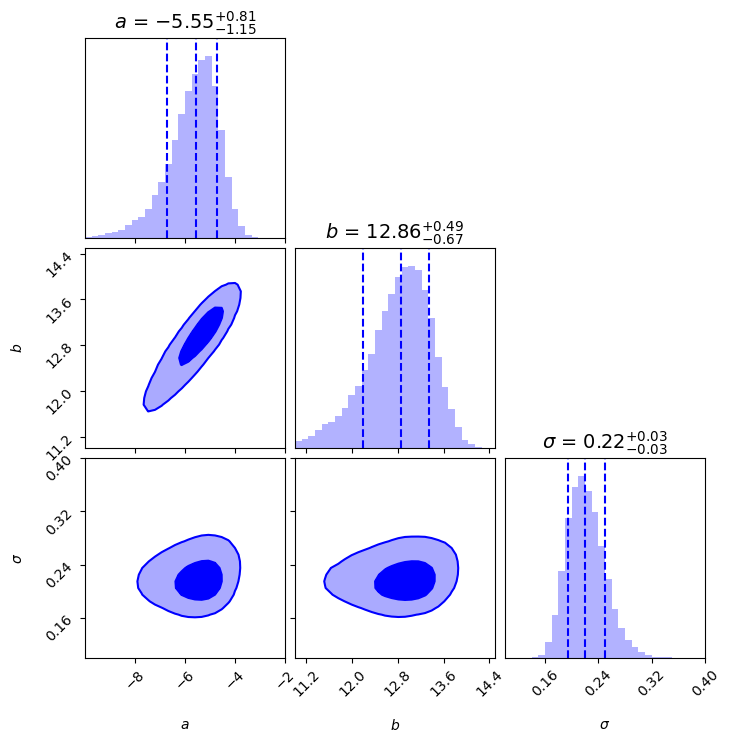

In [37]:
fig = corner.corner(tfr_mcmc_samples.T, bins=30, smooth=1,
                    range=[[-10, -2], [11, 14.5], [0.1, 0.4]],   # Range for a, b, sigma. Adjust as needed.
                    labels=['$a$', '$b$', r'$\sigma$'],
                    levels=(1-np.exp(-0.5), 1-np.exp(-2)),
                    quantiles=[0.16, 0.5, 0.84],
                    color='blue',
                    hist_kwargs={'histtype':'stepfilled', 'alpha':0.3},
                    plot_datapoints=False,
                    fill_contours=True,
                    show_titles=True,
                    title = {'Coma'},
                    title_kwargs={"fontsize": 14})

#fig.savefig('../../Figures/SV/fuji_Coma_corner_20221013.png', dpi=150)

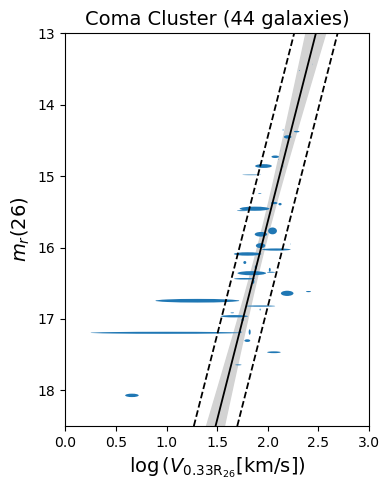

In [40]:
sigmas = hf_itfr.get_sigmas()
xvals = np.linspace(1., 3., 1000)
yvals = a_itfr * (xvals - V0) + b_itfr

# Get the MCMC 1-sigma quantiles to plot with the fit.
y_chain = np.outer(xvals - V0, tfr_mcmc_samples[0]) + tfr_mcmc_samples[1]
y_chain_quantiles = np.quantile(y_chain, [0.1587, 0.8414], axis=1)

# Pack info into data
data = [np.log10(SGA_TF['V_0p33R26']), SGA_TF['R_MAG_SB26']]
x_err = 0.434*SGA_TF['V_0p33R26_err']/SGA_TF['V_0p33R26']
y_err = SGA_TF['R_MAG_SB26_ERR']
corr_xy = np.zeros_like(x_err)

# Generate ellipses
ells = [
    Ellipse(
        xy=[data[0][i], data[1][i]],
        width=2*y_err[i],
        height=2*x_err[i],
        angle=np.rad2deg(np.arccos(corr_xy[i])),
    )
    for i in range(len(data[0]))
]
# Make the plot
fig, ax = plt.subplots(figsize=(4,5), tight_layout=True)
ax.fill_between(xvals, y_chain_quantiles[0], y_chain_quantiles[1], color="lightgray")
for i, e in enumerate(ells):
    ax.add_artist(e)
    e.set_edgecolor('None')
ax.plot(xvals, yvals, c="k", marker="None", ls="-", lw=1.3)
ax.plot(xvals - hf_itfr.vert_scat, yvals, c="k", marker="None", ls="--", lw=1.3)
ax.plot(xvals + hf_itfr.vert_scat, yvals, c="k", marker="None", ls="--", lw=1.3)
ax.set_xlabel(r"$\log{(V_\mathrm{0.33R_{26}} [\mathrm{km/s}])}$", fontsize=14)
ax.set_ylabel(r"$m_r(26)$", fontsize=14)
ax.set_title("Coma Cluster ({} galaxies)".format(len(SGA_TF)), fontsize = 14)
ax.set_xlim(0, 3)
ax.set_ylim(18.5, 13);

#plt.savefig('../../Figures/SV/fuji_Coma_TFR_20221013.png', dpi=150)